# Comparison of Station Data and HRDPS

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import math

In [2]:
#bring in data
hrdps = xr.open_dataset("hrdps_day_avgs_postSep2014.nc")
racerocks = pd.read_csv("RaceRocks.csv")
sheringham = pd.read_csv("Sheringham.csv")
angeles = pd.read_csv("PortAngeles.csv",header=0).drop(axis=0, index=0)
neah = pd.read_csv("neah.csv",header=0).drop(axis=0, index=0)

hrdps_lat = pd.read_csv('hrdps_lat.csv',header=None)[0].to_numpy()
hrdps_lon = pd.read_csv('hrdps_lon.csv',header=None)[0].to_numpy()

/home/rbeutel/anaconda3/envs/eosc510/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (0,1,2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/home/rbeutel/anaconda3/envs/eosc510/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (0,1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
neah['WDIR']=pd.to_numeric(neah['WDIR'])
neah['WSPD']=pd.to_numeric(neah['WSPD'])
angeles['WDIR']=pd.to_numeric(angeles['WDIR'])
angeles['WSPD']=pd.to_numeric(angeles['WSPD'])

In [5]:
#trim hrdps data to fit into timespan
a= hrdps.sel(time_counter=slice('2015-01-01T00:00:00.000000000', '2016-02-28T00:00:00.000000000'))
b= hrdps.sel(time_counter=slice('2016-03-01T00:00:00.000000000', '2020-02-28T00:00:00.000000000'))
c= hrdps.sel(time_counter=slice('2020-03-01T00:00:00.000000000', '2020-12-31T00:00:00.000000000'))
hrdps= xr.concat([a,b,c],dim='time_counter')

In [6]:
#generate dates that current extend of hrdps data falls within
time2015 = pd.date_range(start=datetime.datetime(2015,1,1),end=datetime.datetime(2020,12,31))
time2015 = np.delete(time2015,[list(time2015).index(datetime.datetime(2016,2,29)),list(time2015).index(datetime.datetime(2020,2,29))])

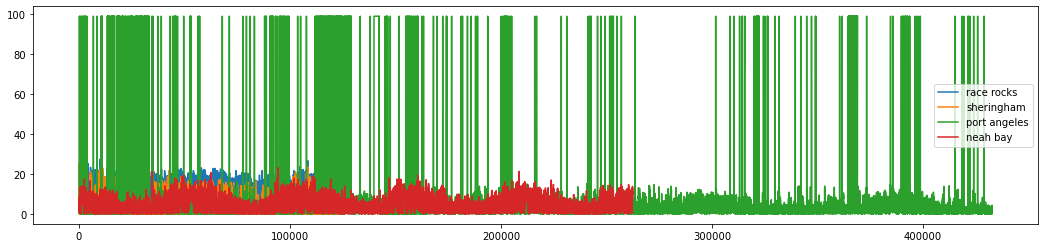

In [7]:
#plot the wind data at both stations
plt.figure(figsize=(18,4))
plt.plot(racerocks['Wind Spd (km/h)']*1000*(1/3600),label='race rocks')
plt.plot(sheringham['Wind Spd (km/h)']*1000*(1/3600),label='sheringham') #much more gaps in sheringham wind data (pressure is comparible), focus on racerocks
plt.plot(angeles['WSPD'],label='port angeles')
plt.plot(neah['WSPD'],label='neah bay')
plt.legend()

^ port angeles is behaving very weirdly, lets see if this is fixed once the daily average is taken

In [8]:
racerocks['Date/Time (LST)']=pd.to_datetime(racerocks['Date/Time (LST)'])
sheringham['Date/Time (LST)']=pd.to_datetime(sheringham['Date/Time (LST)'])
neah['Date/Time']=pd.to_datetime(neah['Date/Time'])
angeles['Date/Time']=pd.to_datetime(angeles['Date/Time'])

In [9]:
#take daily average
RR_davg = racerocks.resample('D', on='Date/Time (LST)').mean()
SH_davg = sheringham.resample('D', on='Date/Time (LST)').mean()
PA_davg = angeles.resample('D', on='Date/Time').mean()
NB_davg = neah.resample('D', on='Date/Time').mean()

In [10]:
#trim data to be for same time extent as hrdps
#racerocks:
RR_davg = RR_davg[min(time2015):max(time2015)]
RR_davg = RR_davg.drop([datetime.datetime(2016,2,29),datetime.datetime(2020,2,29)],axis=0)

#sheringham
SH_davg = SH_davg[min(time2015):max(time2015)]
SH_davg = SH_davg.drop([datetime.datetime(2016,2,29),datetime.datetime(2020,2,29)],axis=0)

#port angeles
PA_davg = PA_davg[min(time2015):]
PA_davg = PA_davg.drop(datetime.datetime(2016,2,29),axis=0)

#neah bay
NB_davg = NB_davg[min(time2015):]
NB_davg = NB_davg.drop(datetime.datetime(2016,2,29),axis=0)

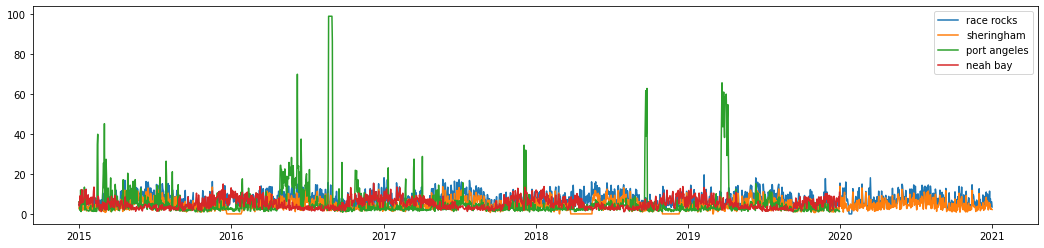

In [11]:
#plot the wind data at all stations again
plt.figure(figsize=(18,4))
plt.plot(RR_davg['Wind Spd (km/h)']*1000*(1/3600),label='race rocks')
plt.plot(SH_davg['Wind Spd (km/h)']*1000*(1/3600),label='sheringham') #much more gaps in sheringham wind data (pressure is comparible), focus on racerocks
plt.plot(PA_davg['WSPD'],label='port angeles')
plt.plot(NB_davg['WSPD'],label='neah bay')
plt.legend()

^still dont think that it is a good idea to use port angeles data based on this

In [12]:
#flip the direction data so that it is the same way that ocenaographers look at it
for i in range(len(RR_davg['Wind Dir (10s deg)'])):
    RR_davg['Wind Dir (10s deg)'][i]=RR_davg['Wind Dir (10s deg)'][i]+18
    SH_davg['Wind Dir (10s deg)'][i]=SH_davg['Wind Dir (10s deg)'][i]+18
    if RR_davg['Wind Dir (10s deg)'][i]>=36:
        RR_davg['Wind Dir (10s deg)'][i]=RR_davg['Wind Dir (10s deg)'][i]-36
    if SH_davg['Wind Dir (10s deg)'][i]>=36:
        SH_davg['Wind Dir (10s deg)'][i]=SH_davg['Wind Dir (10s deg)'][i]-36

for i in range(len(PA_davg['WDIR'])):
    PA_davg['WDIR'][i]=PA_davg['WDIR'][i]+180
    NB_davg['WDIR'][i]=NB_davg['WDIR'][i]+180
    if PA_davg['WDIR'][i]>=360:
        PA_davg['WDIR'][i]=PA_davg['WDIR'][i]-360
    if NB_davg['WDIR'][i]>=360:
        NB_davg['WDIR'][i]=NB_davg['WDIR'][i]-360

## Find the index of the closest HRDPS grid cell
#### Race Rocks

In [23]:
#want to isolate HRDPS data from nav_lat and nav_lon close to RaceRocks
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

#Racerocks located at lat =48.3 lon =-123.53
lat = racerocks['Latitude (y)'][0]
lon = racerocks['Longitude (x)'][0]+360 #the lat and lon we want to aim for
buffer = 0.01 #play around in this until narrowed in on one best values
ind_RR=0

for i in range(len(hrdps_lon)):
    if hrdps_lon[i] > (lon-buffer) and hrdps_lon[i] < (lon+buffer) and hrdps_lat[i] > (lat-buffer) and hrdps_lat[i] < (lat+buffer):
        ind_RR=i

# closest = find_nearest(hrdps_lat,racerocks['Latitude (y)'][0])
# lat_ind = np.where(hrdps_lat == closest)[0][0]

# closest = find_nearest(hrdps_lon,racerocks['Longitude (x)'][0]+360)
# lon_ind = np.where(hrdps_lon == closest)[0][0]

print('HRDPS closest lat= '+str(hrdps_lat[ind_RR])+', closest lon= '+str(hrdps_lon[ind_RR]))

HRDPS closest lat= 48.29035764694796, closest lon= 236.4652931642128


#### Sheringham

In [24]:
lat = sheringham['Latitude (y)'][0]
lon = sheringham['Longitude (x)'][0]+360 #the lat and lon we want to aim for
buffer = 0.01 #play around in this until narrowed in on one best values
ind_SH=0

for i in range(len(hrdps_lon)):
    if hrdps_lon[i] > (lon-buffer) and hrdps_lon[i] < (lon+buffer) and hrdps_lat[i] > (lat-buffer) and hrdps_lat[i] < (lat+buffer):
        ind_SH=i

print('HRDPS closest lat= '+str(hrdps_lat[ind_SH])+', closest lon= '+str(hrdps_lon[ind_SH]))

HRDPS closest lat= 48.371361046585406, closest lon= 236.0877742159108


#### Neah Bay

In [25]:
lat = 48.493
lon = -124.726+360 #the lat and lon we want to aim for
buffer = 0.007 #play around in this until narrowed in on one best values
ind_NB=0

for i in range(len(hrdps_lon)):
    if hrdps_lon[i] > (lon-buffer) and hrdps_lon[i] < (lon+buffer) and hrdps_lat[i] > (lat-buffer) and hrdps_lat[i] < (lat+buffer):
        ind_NB=i

print('HRDPS closest lat= '+str(hrdps_lat[ind_NB])+', closest lon= '+str(hrdps_lon[ind_NB]))

HRDPS closest lat= 48.49932174278885, closest lon= 235.27212538552274


## Pre-reconstruction comparison

In [26]:
u= hrdps.u_wind.values
v = hrdps.v_wind.values
speed_temp = np.sqrt(np.add(np.square(u),np.square(v)))
direc_temp = np.arctan2(u,v)

In [27]:
#get into shape we can work with
speed_hrdps = np.empty((np.shape(speed_temp)[1]*np.shape(speed_temp)[2],np.shape(speed_temp)[0]))
for i in range(np.shape(speed_temp)[0]):
    speed_hrdps[:,i] = np.reshape(speed_temp[i],(np.shape(speed_temp)[1]*np.shape(speed_temp)[2],))
    
direc_hrdps = np.empty((np.shape(direc_temp)[1]*np.shape(direc_temp)[2],np.shape(direc_temp)[0]))
for i in range(np.shape(direc_temp)[0]):
    direc_hrdps[:,i] = np.reshape(direc_temp[i],(np.shape(direc_temp)[1]*np.shape(direc_temp)[2],))

In [28]:
#trim so that its just the index we care about 
speed_hrdps_RR=speed_hrdps[ind_RR,:]
direc_hrdps_RR=direc_hrdps[ind_RR,:]

speed_hrdps_SH=speed_hrdps[ind_SH,:]
direc_hrdps_SH=direc_hrdps[ind_SH,:]

speed_hrdps_NB=speed_hrdps[ind_NB,:]
direc_hrdps_NB=direc_hrdps[ind_NB,:]

#### Speed

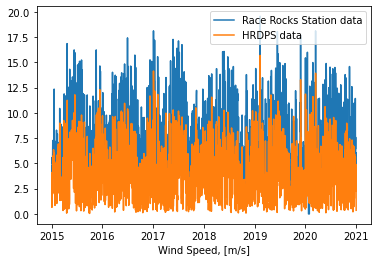

In [29]:
#plot comparison to racerocks
plt.plot(time2015,RR_davg['Wind Spd (km/h)']*1000*(1/3600),label='Race Rocks Station data')
plt.plot(time2015,speed_hrdps_RR, label='HRDPS data')
plt.xlabel('Wind Speed, [m/s]')
plt.legend()

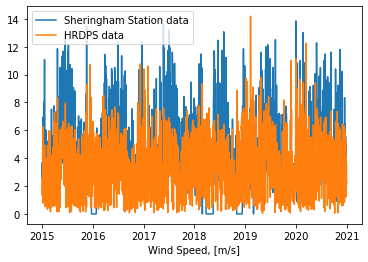

In [30]:
#plot comparison to sheringham
plt.plot(time2015,SH_davg['Wind Spd (km/h)']*1000*(1/3600),label='Sheringham Station data')
plt.plot(time2015,speed_hrdps_SH, label='HRDPS data')
plt.xlabel('Wind Speed, [m/s]')
plt.legend()

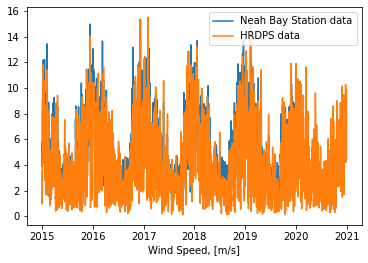

In [31]:
#plot comparison to neah bay
plt.plot(NB_davg['WSPD'],label='Neah Bay Station data')
plt.plot(time2015,speed_hrdps_NB, label='HRDPS data')
plt.xlabel('Wind Speed, [m/s]')
plt.legend()

#### Direction

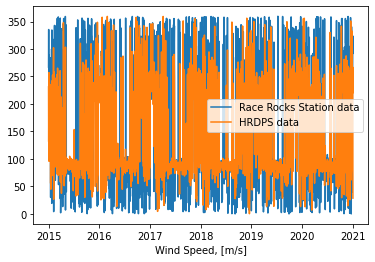

In [32]:
#racerocks direction
#HRPDS direction results are in +ve and -ve radians, must convert to degrees between 0 and 360
for i in range(len(direc_hrdps_RR)):
    if direc_hrdps_RR[i] >0:
        direc_hrdps_RR[i] = direc_hrdps_RR[i]*(180/math.pi)
    if direc_hrdps_RR[i] <0:
        direc_hrdps_RR[i] = direc_hrdps_RR[i]*(180/math.pi)+360


plt.plot(time2015,RR_davg['Wind Dir (10s deg)']*10,label='Race Rocks Station data')
plt.plot(time2015,direc_hrdps_RR, label='HRDPS data')
plt.xlabel('Wind Speed, [m/s]')
plt.legend()

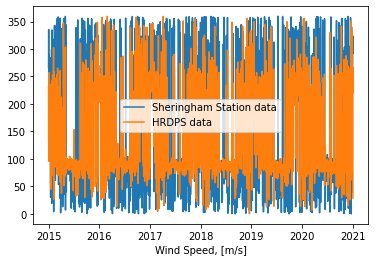

In [33]:
#sheringham direction
#HRPDS direction results are in +ve and -ve radians, must convert to degrees between 0 and 360
for i in range(len(direc_hrdps_SH)):
    if direc_hrdps_SH[i] >0:
        direc_hrdps_SH[i] = direc_hrdps_SH[i]*(180/math.pi)
    if direc_hrdps_SH[i] <0:
        direc_hrdps_SH[i] = direc_hrdps_SH[i]*(180/math.pi)+360


plt.plot(time2015,RR_davg['Wind Dir (10s deg)']*10,label='Sheringham Station data')
plt.plot(time2015,direc_hrdps_RR, label='HRDPS data')
plt.xlabel('Wind Speed, [m/s]')
plt.legend()

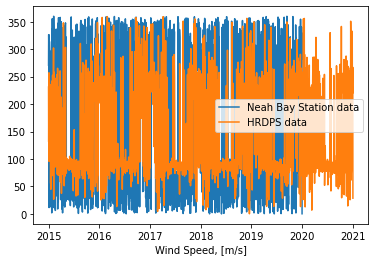

In [34]:
#neah bay direction
#HRPDS direction results are in +ve and -ve radians, must convert to degrees between 0 and 360
for i in range(len(direc_hrdps_NB)):
    if direc_hrdps_NB[i] >0:
        direc_hrdps_NB[i] = direc_hrdps_NB[i]*(180/math.pi)
    if direc_hrdps_NB[i] <0:
        direc_hrdps_NB[i] = direc_hrdps_NB[i]*(180/math.pi)+360


plt.plot(NB_davg['WDIR'],label='Neah Bay Station data')
plt.plot(time2015,direc_hrdps_RR, label='HRDPS data')
plt.xlabel('Wind Speed, [m/s]')
plt.legend()

## Reconstruction comparison

In [35]:
#bring in PCA results
direc_eigvecs = pd.read_csv('direc_hrdps_eigvecs.csv',header=None).to_numpy()
direc_fracvar = pd.read_csv('direc_hrdps_fracVar.csv',header=None)[0].to_numpy()
direc_PCs = pd.read_csv('direc_hrdps_PCs.csv',header=None).to_numpy()
speed_eigvecs = pd.read_csv('speed_hrdps_eigvecs.csv',header=None).to_numpy()
speed_fracvar = pd.read_csv('speed_hrdps_fracVar.csv',header=None)[0].to_numpy()
speed_PCs = pd.read_csv('speed_hrdps_PCs.csv',header=None).to_numpy()

In [36]:
#bring in seasonal cycle results
season_speed = pd.read_csv('speed_daily_seasonal.csv',header=None).to_numpy()
season_direc = pd.read_csv('direc_daily_seasonal.csv',header=None).to_numpy()

In [37]:
speed_eigvecs_RR = speed_eigvecs[:,ind_RR]
direc_eigvecs_RR = direc_eigvecs[:,ind_RR]

speed_eigvecs_NB = speed_eigvecs[:,ind_NB]
direc_eigvecs_NB = direc_eigvecs[:,ind_NB]

In [38]:
#determine the number of modes required for x% variance to be explained in speed
x= 0.90
kk = 0

for i in range(len(speed_fracvar)):
    kk+=speed_fracvar[i]
    if kk >= x:
        n_speed=i 
        break
print(str(n_speed)+" modes required to account for " +str(x*100)+"% of the variance.")

7 modes required to account for 90.0% of the variance.


In [39]:
#determine the number of modes required for x% variance to be explained in direction
x= 0.90
kk = 0

for i in range(len(direc_fracvar)):
    kk+=direc_fracvar[i]
    if kk >= x:
        n_direc=i 
        break
print(str(n_direc)+" modes required to account for " +str(x*100)+"% of the variance.")

306 modes required to account for 90.0% of the variance.


#### Race Rocks
Speed

In [49]:
#reconstruct 
eigvecs = speed_eigvecs_RR[:,np.newaxis]
REC = eigvecs[:n_speed,:].T@speed_PCs[:,:n_speed].T# + np.mean(pd.DataFrame.to_numpy(d[2:]))
REC = REC[0,:]

In [50]:
#add seasonal cycle back
#first we need to remove all irrelevant infro from season_speed (only care about the tile closest to RaceRocks)
season6yr_speed = season_speed[ind_RR,:]

#then make this cycle for the full 6 year run and add to the reconstructed data
nyears=6
REC = REC+ np.tile(season6yr_speed,(1,nyears))
REC = REC[0,:]

In [51]:
#calculate the correlation between racerocks and HRDPS
r = np.corrcoef(REC,RR_davg['Wind Spd (km/h)']*1000*(1/3600))[0][1]

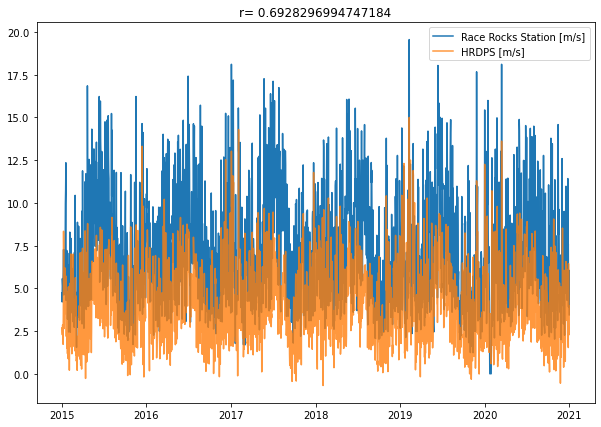

In [52]:
plt.figure(figsize=(10,7))
plt.plot(time2015,RR_davg['Wind Spd (km/h)']*1000*(1/3600),label='Race Rocks Station [m/s]')#,alpha=0.9)
plt.plot(time2015,REC,alpha=0.8,label='HRDPS [m/s]')
plt.title('r= '+str(r))
plt.legend()

Direction:

In [54]:
#reconstruct 
eigvecs = direc_eigvecs_RR[:,np.newaxis]
REC = eigvecs[:n_direc,:].T@direc_PCs[:,:n_direc].T# + np.mean(pd.DataFrame.to_numpy(d[2:]))
REC = REC[0,:]

In [55]:
#add seasonal cycle back
#first we need to remove all irrelevant infro from season_speed (only care about the tile closest to RaceRocks)
season_direc6yr = season_direc[ind_RR,:]

#then make this cycle for the full 6 year run and add to the reconstructed data
nyears=6
REC = REC+ np.tile(season_direc6yr,(1,nyears))
REC = REC[0,:]

In [56]:
#HRPDS direction results are in +ve and -ve radians, must convert to degrees between 0 and 360
for i in range(len(REC)):
    if REC[i] >0:
        REC[i] = REC[i]*(180/math.pi)
    if REC[i] <0:
        REC[i] = REC[i]*(180/math.pi)+360

In [57]:
#calculate the correlation between racerocks and HRDPS
r = np.corrcoef(REC,RR_davg['Wind Dir (10s deg)']*10)[0][1]

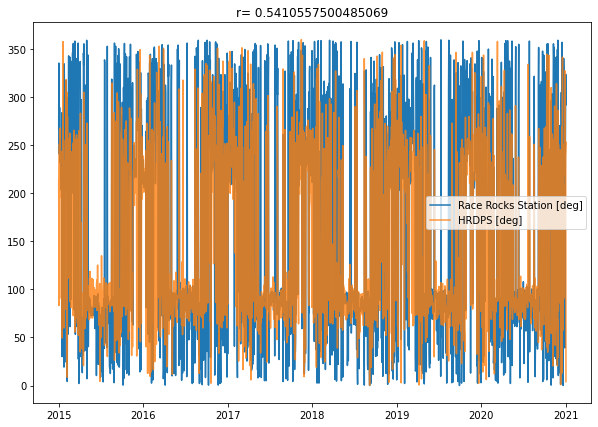

In [58]:
plt.figure(figsize=(10,7))
plt.plot(time2015,RR_davg['Wind Dir (10s deg)']*10,label='Race Rocks Station [deg]')#,alpha=0.9)
plt.plot(time2015,REC,alpha=0.8,label='HRDPS [deg]')
plt.title('r= '+str(r))
plt.legend()

#### Neah Bay
Speed

In [80]:
#reconstruct 
eigvecs = speed_eigvecs_NB[:,np.newaxis]
REC = eigvecs[:n_speed,:].T@speed_PCs[:,:n_speed].T# + np.mean(pd.DataFrame.to_numpy(d[2:]))
REC = REC[0,:len(NB_davg)] #need to trim a bit since the NOAA data doesn't go all the way to 2021

In [81]:
#add seasonal cycle back
#first we need to remove all irrelevant infro from season_speed (only care about the tile closest to RaceRocks)
season5yr_speed = season_speed[ind_NB,:]

#then make this cycle for the full 6 year run and add to the reconstructed data
nyears=5
REC = REC+ np.tile(season5yr_speed,(1,nyears))
REC = REC[0,:]

In [82]:
#calculate the correlation between racerocks and HRDPS
r = np.corrcoef(REC,NB_davg['WSPD'])[0][1]

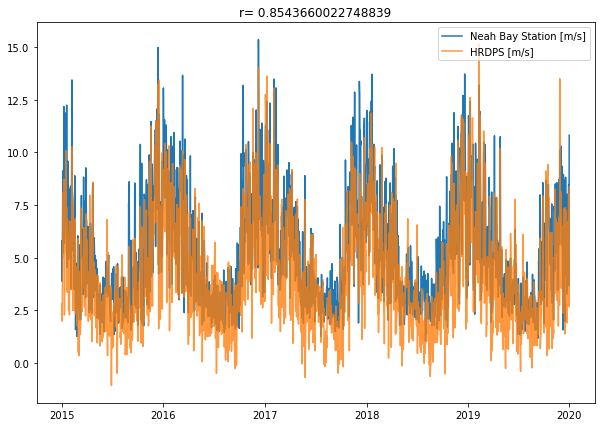

In [83]:
plt.figure(figsize=(10,7))
plt.plot(time2015[:len(NB_davg)],NB_davg['WSPD'],label='Neah Bay Station [m/s]')#,alpha=0.9)
plt.plot(time2015[:len(NB_davg)],REC,alpha=0.8,label='HRDPS [m/s]')
plt.title('r= '+str(r))
plt.legend()

Direction

In [84]:
#reconstruct 
eigvecs = direc_eigvecs_NB[:,np.newaxis]
REC = eigvecs[:n_direc,:].T@direc_PCs[:,:n_direc].T# + np.mean(pd.DataFrame.to_numpy(d[2:]))
REC = REC[0,:len(NB_davg)]

In [85]:
#add seasonal cycle back
#first we need to remove all irrelevant infro from season_speed (only care about the tile closest to RaceRocks)
season_direc5yr = season_direc[ind_NB,:]

#then make this cycle for the full 6 year run and add to the reconstructed data
nyears=5
REC = REC+ np.tile(season_direc5yr,(1,nyears))
REC = REC[0,:]

In [86]:
#HRPDS direction results are in +ve and -ve radians, must convert to degrees between 0 and 360
for i in range(len(REC)):
    if REC[i] >0:
        REC[i] = REC[i]*(180/math.pi)
    if REC[i] <0:
        REC[i] = REC[i]*(180/math.pi)+360

In [87]:
#calculate the correlation between racerocks and HRDPS
r = np.corrcoef(REC,NB_davg['WDIR'])[0][1]

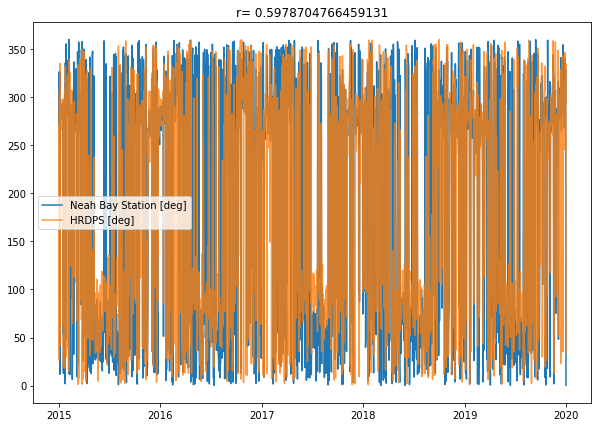

In [88]:
plt.figure(figsize=(10,7))
plt.plot(time2015[:len(NB_davg)],NB_davg['WDIR'],label='Neah Bay Station [deg]')#,alpha=0.9)
plt.plot(time2015[:len(NB_davg)],REC,alpha=0.8,label='HRDPS [deg]')
plt.title('r= '+str(r))
plt.legend()